In [28]:
import numpy.linalg as npl

import math
import numbers
import torch
from torch import nn
from torch.nn import functional as F

import warnings
warnings.filterwarnings('ignore')
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.nn.functional import relu
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PairwiseDistance 
import torch.nn as nn
import torch.fft
from torch_topological.nn import SummaryStatisticLoss
from torch_topological.nn import VietorisRipsComplex
from tqdm import tqdm
import torch
import torch.optim as optim

def rotation_matrix(theta, degrees=True, **kwargs) -> np.ndarray:
    """
    Creates a 2D rotation matrix for theta
    Parameters
    ----------
    theta : float
        angle offset wrt. the cardinal x-axis
    degrees : boolean
        Whether to use degrees or radians
    Returns
    -------
    rotmat : np.ndarray
        the 2x2 rotation matrix
    Examples
    --------
    >>> import numpy as np
    >>> x = np.ones(2) / np.sqrt(2)
    >>> rotmat = rotation_matrix(45)
    >>> tmp = rotmat @ x
    >>> eps = 1e-8
    >>> np.sum(np.abs(tmp - np.array([0., 1.]))) < eps
    True
    """
    # convert to radians
    theta = theta * np.pi / 180 if degrees else theta
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c, -s), (s, c)))

torch.autograd.set_detect_anomaly(True)
class GridPhases(torch.nn.Module):
    def __init__(self, N, pos, batch_size, ks, non_negative, init_phases, seed=42):
        super(GridPhases, self).__init__()
        self.pos = pos
        torch.manual_seed(seed)
        self.N = N
        if init_phases == 'uniform':
            self.phases = torch.nn.Parameter(
              torch.rand(N, 2),
              requires_grad=True)
        elif init_phases == 'normal':
            self.phases = torch.nn.Parameter(
              torch.randn(N, 2)/10 + torch.tensor((0.5,0.5)),
              requires_grad=True)
            
        self.ks = ks
        self.num_times = len(pos)
        self.batch_size = batch_size
        self.non_negative = non_negative
        
        
    def forward(self): 
        activity = torch.zeros(self.batch_size, self.N)

        for i in range(self.batch_size):
            activity[i,:] = torch.sum(torch.cos(torch.matmul((self.pos[i, :] - self.phases), 
                                                                  self.ks.T)), axis=-1)
            
        if self.non_negative:
            activity = torch.relu(activity)
        else:
            activity = 2 * (activity / 3 + 0.5) / 3       

        return activity

    
class DecodePos(torch.nn.Module):
    def __init__(self, N, non_negative, init_weights, seed=42):
        super(DecodePos, self).__init__()
        if init_weights == 'normal':
            self.xyweights = torch.nn.Parameter(
                torch.randn(N, 2) + torch.tensor((0.5,0.5)),
              requires_grad=True)
        elif init_weights == 'uniform':
            self.xyweights = torch.nn.Parameter(
                torch.rand(N, 2),
              requires_grad=True)
        self.non_negative = non_negative
        
    def forward(self, activity, ): 
        if self.non_negative:
            return torch.matmul(activity, torch.relu(self.xyweights))        
        else:
            return torch.matmul(activity, self.xyweights)
            

    

class OptimPhase:
    def __init__(
            self,
            pos,  # time steps x 2 
            ks,
            non_negative = True,
            non_negative_weigths = True,
            N = 100, # numer neurons
            batch_size= 16,
            epochs=3,
            train_steps=10,  # per epoch
            lr1=1e-2,
            lr2=1e-2,
            seed=47,
            verbose=True,  # whether to print and plot intermediate statistics
            device="cpu",
            num_worse=3,
            init_phases = 'uniform',
            init_weights = 'normal'
            # how many epochs loss may get worse before stopping
    ):
        # Parameters
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_steps = train_steps
        self.lr1 = lr1
        self.lr2 = lr2
        self.seed = seed
        self.verbose = verbose
        self.num_worse = num_worse
        self.num_times = len(pos)
        self.pos = pos
        # Setup Data, Model, Optimizer
        self.decode = DecodePos(N, non_negative_weigths, init_weights).to(device)        
        self.model = GridPhases(N, pos, batch_size, ks, non_negative, init_phases).to(device)
        self.optimizer = torch.optim.Adam([{'params': self.model.parameters(), 'lr': lr1},
                                           {'params': self.decode.parameters(), 'lr': lr2}], )

    def train(self):
        worse = 0  # counter for early stopping
        running_loss = 0.0
        running_loss_top = 0.0
        running_loss_rest = 0.0
        run_loss, run_bars = [], []
        t0 = time.time()
        self.stats = {'phases': [], 'loss': []}
        
        for i in range(self.epochs * self.train_steps + 1):
            # training step
            self.optimizer.zero_grad()
            out = self.model()
            layer_out = self.decode(out)

            loss = torch.sum(torch.square(self.pos -layer_out))
            print(loss)
            self.stats['loss'].append(loss.item())
            self.stats['phases'].append(torch.tensor(self.model.phases))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.lr1)
            torch.nn.utils.clip_grad_norm_(self.decode.parameters(), self.lr2)
            self.optimizer.step()            
            print('')
            
            if i > -1 and not (i % self.train_steps):
                plt.figure()
                plt.plot([0,0], [0,1], c = 'k', zorder = -1)
                plt.plot([0,1], [0,0], c = 'k', zorder = -1)                
                plt.scatter(layer_out.detach().numpy()[:,0],
                            layer_out.detach().numpy()[:,1])
                                
                log = 'run=%s, time=%.2fs' % (i, time.time() - t0)
                print(log)
                fig, ax = plt.subplots(1,1)
                ax.scatter(*self.stats['phases'][np.argmin(self.stats['loss'])].T%1)
                ax.set_xlim([0,1])
                ax.set_ylim([0,1])
                ax.set_aspect('equal', 'box')
                
                plt.figure()
                plt.plot(self.stats['loss'])
                # early stopping
                ii = int(i/self.train_steps)
                if ii>0:
                    mincurr = np.min(self.stats['loss'])
                    mincurrtrain = np.min(self.stats['loss'][-self.train_steps:]) 
                    log = 'min=%.2f and mincurr%.2f' % (mincurr, mincurrtrain)
                    print(log)
                    if mincurrtrain > mincurr:
                        worse += 1
                        
                        if worse > self.num_worse:
                            print('Early stopping at iteration', i)
                            break
                plt.show()
                print('')
        print('Training finished.')


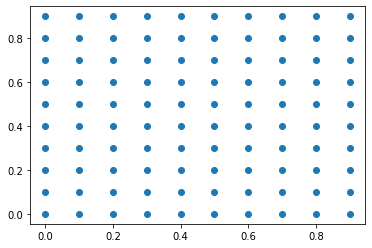

In [2]:
orientation_offset=0
f=1
rot_hex=60
n_comps_hex=3
non_negative=True
add=True
a = 1
relative_R_hex = rotation_matrix(rot_hex)
init_R = rotation_matrix(orientation_offset)

k1 = np.array([1.0, 0.0])  # init wave vector. unit length in x-direction
k1 = init_R @ k1

ks_hex = np.array([npl.matrix_power(relative_R_hex, k) @ k1 for k in range(n_comps_hex)])* 2 * np.pi*f
ks_hex = ks_hex * 2 / (a*np.sqrt(3)) # user-defined spatial frequency
#ks_hex = torch.tensor(ks_hex, dtype = torch.float)  # spatial angular frequency (unit-movement in space is one period)
ks_hex = torch.from_numpy(ks_hex)


rot_sqr=90
n_comps_sqr=2
relative_R_sqr = rotation_matrix(rot_sqr)
ks_sqr = np.array([npl.matrix_power(relative_R_sqr, k) @ k1 for k in range(n_comps_sqr)])
ks_sqr *= 2 * np.pi  # spatial angular frequency (unit-movement in space is one period)
ks_sqr *= f  # user-defined spatial frequency
ks_sqr = torch.from_numpy(ks_sqr)


xymesh = torch.meshgrid((torch.linspace(0,1,11, dtype=float)[:-1],torch.linspace(0,1,11, dtype=float)[:-1]))
xx = xymesh[0].flatten()
yy = xymesh[1].flatten()

pos1 = torch.zeros(100,2, dtype=float)
pos1[:,0] = xx #+ torch.rand(64, dtype = float)*0.05
pos1[:,1] = yy #+ torch.rand(64, dtype = float)*0.05

plt.scatter(pos1[:,0], pos1[:,1])

0.00414729118347168
tensor(46.3108, dtype=torch.float64, grad_fn=<SumBackward0>)

run=0, time=2.52s


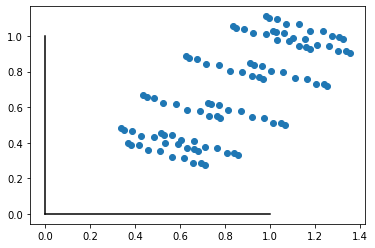

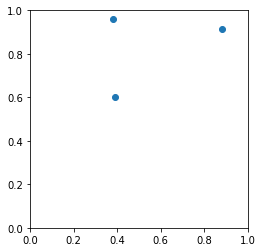

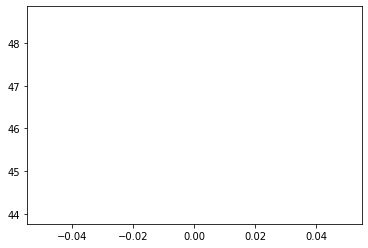


tensor(43.4903, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(40.8901, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(38.5142, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(36.3508, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(34.3654, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(32.5336, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(30.8410, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(29.2728, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(27.8128, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(26.4445, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(25.1536, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(23.9298, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(22.7676, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(21.6652, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(20.6237, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(19.6446, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(

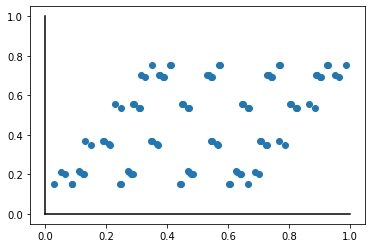

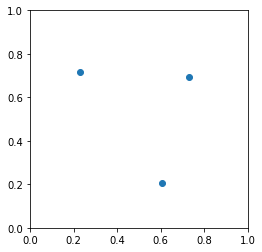

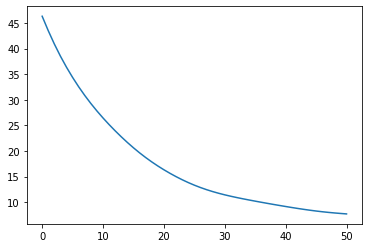


tensor(7.6336, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.5562, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.4852, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.4202, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.3609, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.3070, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.2560, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.2061, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.1555, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.1044, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.0530, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.0026, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.9533, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.9048, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.8561, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.8068, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.7575, dtype=to

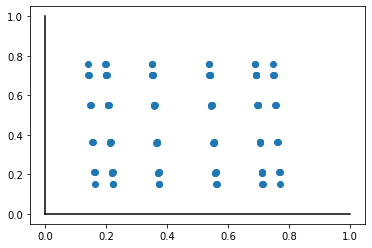

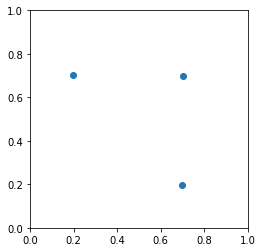

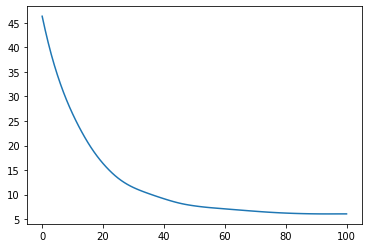


tensor(6.0810, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0801, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0789, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0776, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0763, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0750, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0744, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0740, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0739, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0742, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0751, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0753, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0751, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0748, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0749, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0745, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0738, dtype=to

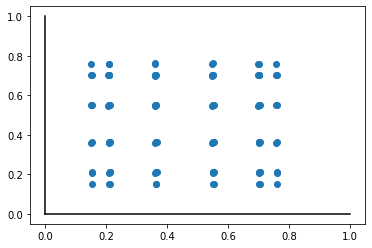

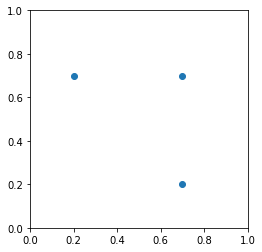

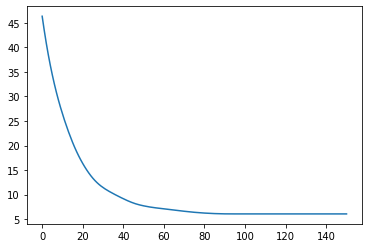


tensor(6.0738, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0740, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0740, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0738, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0739, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0737, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0739, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0739, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0736, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0740, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0741, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0736, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0736, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0741, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0738, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0738, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0740, dtype=to

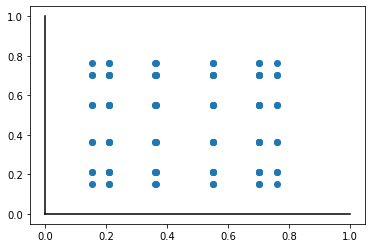

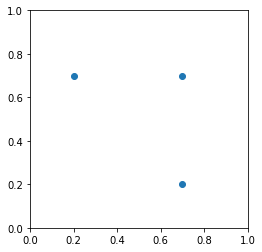

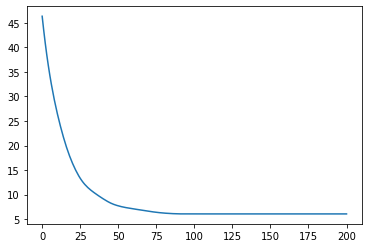


tensor(6.0735, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0740, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0739, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0737, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0737, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0737, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0736, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0737, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0736, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0737, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0736, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0738, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0737, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0737, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0736, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0737, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0737, dtype=to

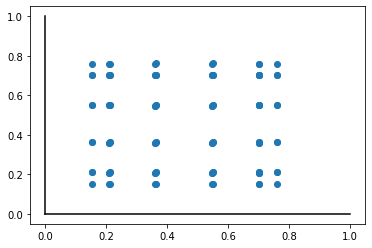

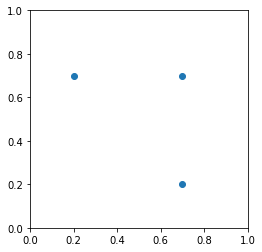

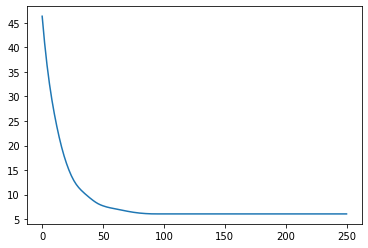


Training finished.


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 3,
              batch_size = 100,
              epochs = 5,
              train_steps = 50,
              lr1 = 0.01,
              lr2 = 0.01
            )
print(time.time()-t0)
model1.train()

0.0059888362884521484
tensor(21222.9529, dtype=torch.float64, grad_fn=<SumBackward0>)

run=0, time=2.44s


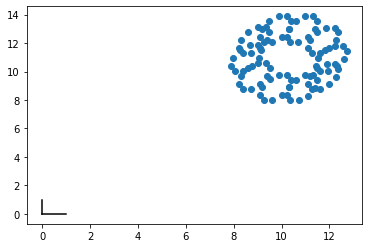

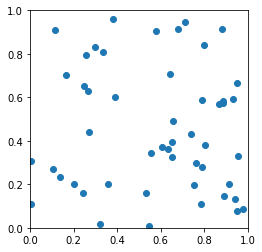

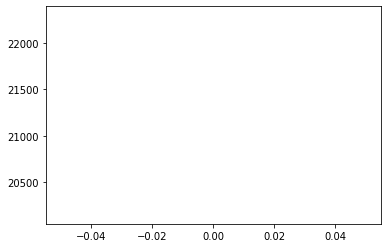


tensor(20573.4417, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(19972.4707, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(19409.3549, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(18878.8683, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(18372.0411, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(17887.9036, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(17415.6089, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(16956.4289, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(16514.4801, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(16082.6049, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(15663.9990, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(15256.5023, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(14857.8389, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(14467.6357, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(14092.9098, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(13725.0987, dtype

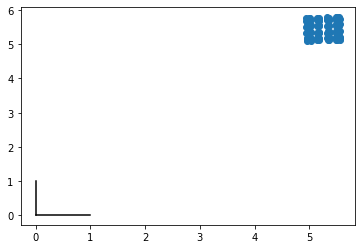

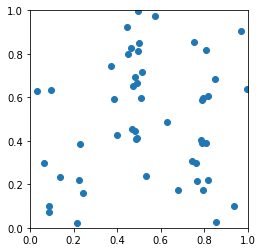

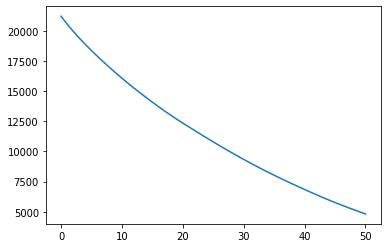


tensor(4641.5541, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4467.3913, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4296.4467, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4128.6822, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3964.1600, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3804.2996, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3649.2129, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3497.6202, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3351.5401, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3211.0362, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3073.8339, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2941.8240, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2812.4654, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2685.8102, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2561.9119, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2443.0073, dtype=torch.float64, 

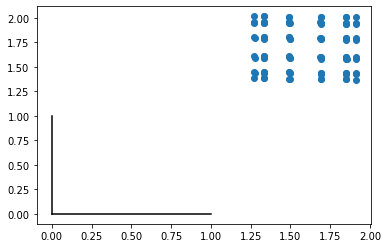

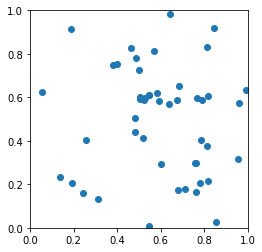

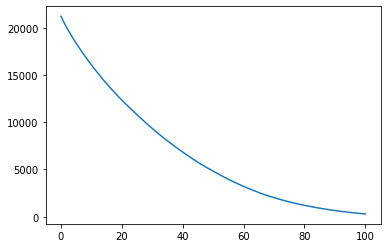


tensor(266.5566, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(243.8825, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(222.1552, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(201.6473, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(182.6703, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(166.4862, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(151.4382, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(137.5425, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(124.3978, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(111.9177, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(100.1310, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(89.0628, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(79.2641, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(70.2654, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(62.4618, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(55.2054, dtype=torch.float64, grad_fn=<SumBackward0

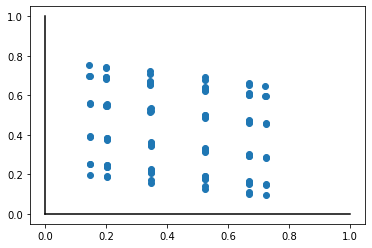

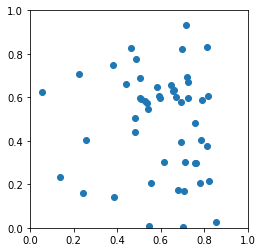

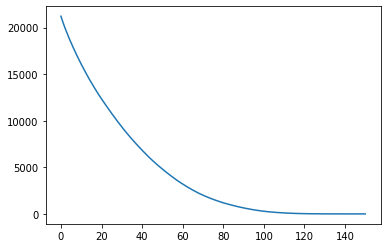


tensor(6.3281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.2413, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1873, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1649, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1527, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1437, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1447, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1555, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1613, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1509, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1268, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1013, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0876, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0818, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0797, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0879, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0984, dtype=to

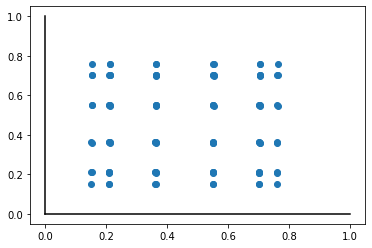

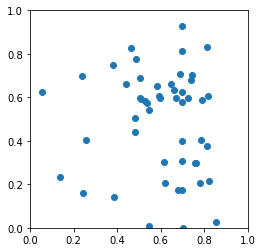

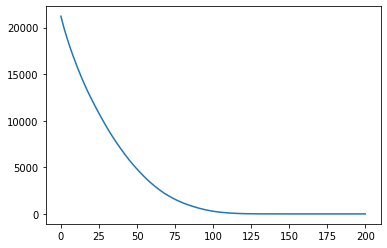


tensor(6.0742, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0748, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0742, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0744, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0751, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0745, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0742, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0741, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0741, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0739, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0746, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0752, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0759, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0743, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0757, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0769, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0753, dtype=to

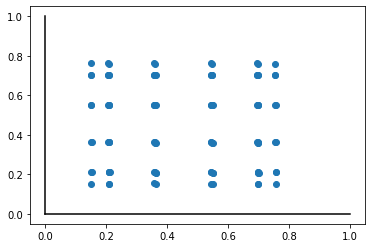

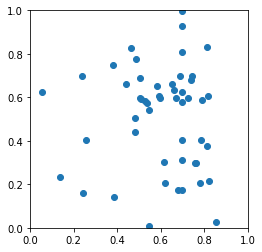

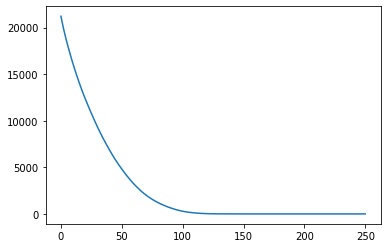


Training finished.


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 50,
              batch_size = 100,
              epochs = 5,
              train_steps = 50,
              lr1 = 0.01,
              lr2 = 0.01
            )
print(time.time()-t0)
model1.train()

21222.952924519603
6.07387146003972


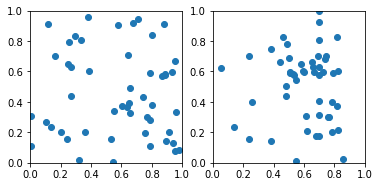

In [17]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,2)
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].scatter(p0[:,0],p0[:,1])
ax[0].set_aspect('equal', 'box')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].scatter(p1[:,0],p1[:,1])
ax[1].set_aspect('equal', 'box')

### 50 neurons, lr1=lr2 = 0.01, init_phases = normal

0.0045588016510009766
tensor(27489.8833, dtype=torch.float64, grad_fn=<SumBackward0>)

run=0, time=2.42s


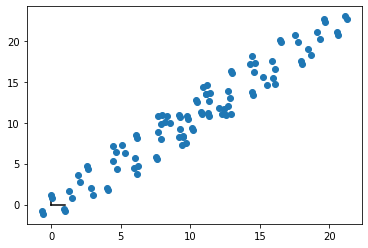

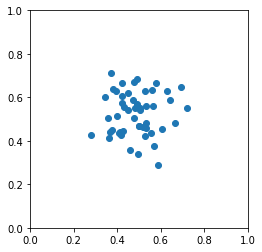

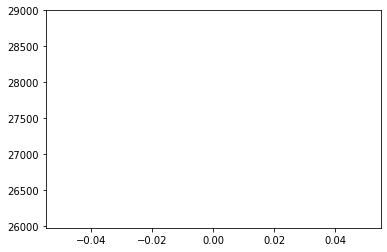


tensor(26354.5869, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(25237.2874, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(24136.4008, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(23059.2338, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(22009.5226, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(21000.4153, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(20031.5700, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(19112.2257, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(18251.8918, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(17446.5400, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(16704.2944, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(16025.6048, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(15408.9662, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(14853.5639, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(14364.4988, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(13930.0549, dtype

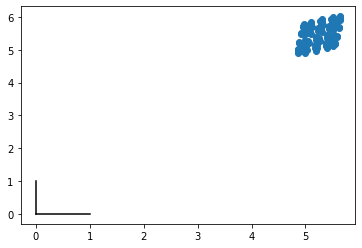

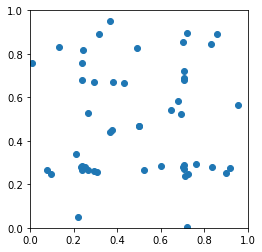

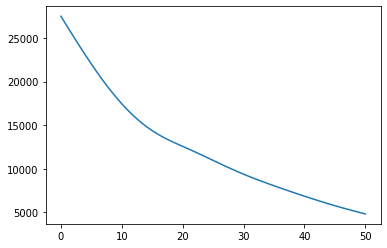


tensor(4640.9597, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4466.2606, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4294.7263, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4126.8159, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3962.5170, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3802.7825, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3648.2601, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3499.2811, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3353.2646, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3211.5678, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3074.7534, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2942.7500, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2813.4787, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2686.9589, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2563.9934, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2446.6434, dtype=torch.float64, 

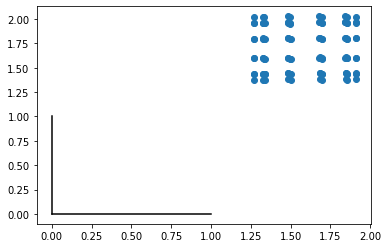

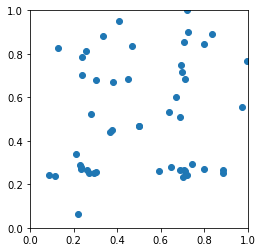

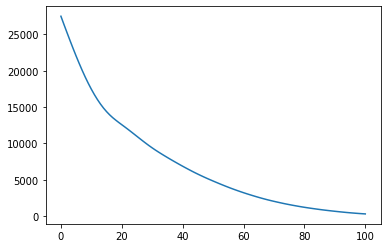


tensor(267.8960, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(245.2166, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(223.4587, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(202.6576, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(183.3005, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(166.9083, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(151.9172, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(138.0636, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(124.9958, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(112.6024, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(100.9149, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(90.0032, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(80.1068, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(71.0404, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(63.0224, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(55.8416, dtype=torch.float64, grad_fn=<SumBackward0

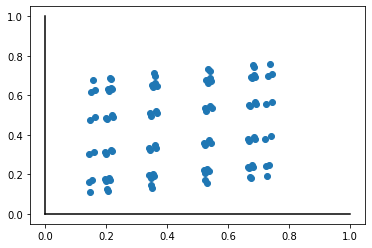

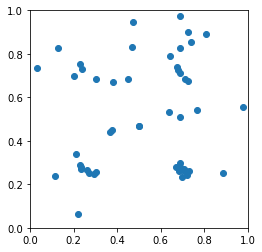

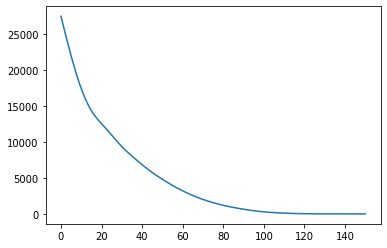


tensor(6.2089, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1652, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1492, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1382, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1298, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1343, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1470, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1492, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1334, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1087, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0933, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0873, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0808, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0833, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0952, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0980, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0928, dtype=to

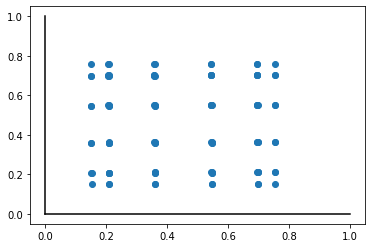

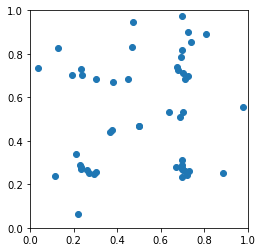

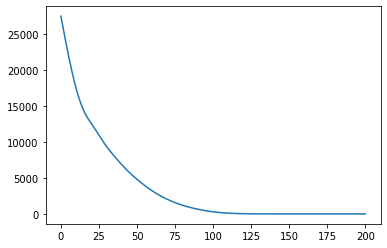


tensor(6.0743, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0739, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0755, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0749, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0753, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0755, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0741, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0743, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0756, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0755, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0743, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0743, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0752, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0746, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0747, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0743, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0747, dtype=to

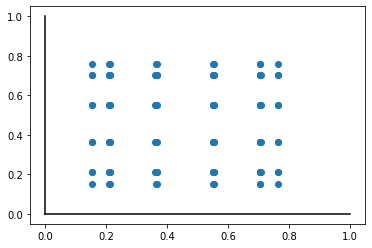

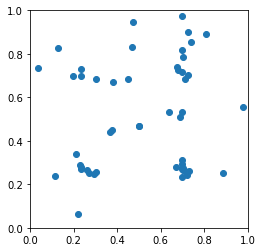

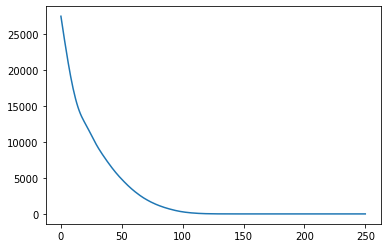


Training finished.


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 50,
              batch_size = 100,
              epochs = 5,
              train_steps = 50,
              lr1 = 0.01,
              lr2 = 0.01,
            init_phases = 'normal'
            )
print(time.time()-t0)
model1.train()

27489.883254136745
6.073850173275037


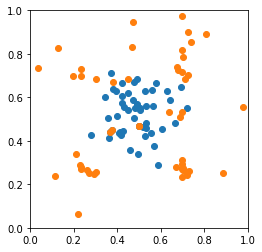

In [21]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

### 50 neurons, lr1=lr2 = 0.05, init_phases = normal

0.1433699131011963
tensor(32822.3875, dtype=torch.float64, grad_fn=<SumBackward0>)

run=0, time=0.84s


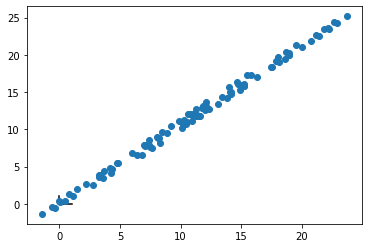

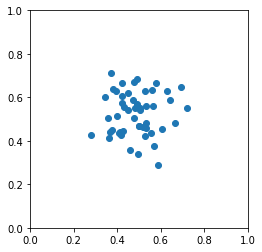

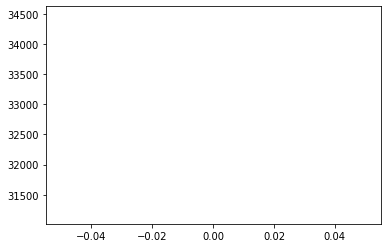


tensor(26751.5505, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(21520.7142, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(17867.1688, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(15916.6602, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(14557.3814, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(13036.5207, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(11406.0937, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(9811.7164, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(8364.9029, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7151.9797, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6122.1012, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5208.4996, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4389.0207, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3632.9010, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2980.6600, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(2411.0104, dtype=torch.fl

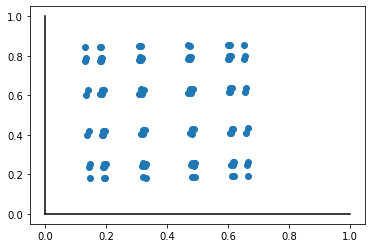

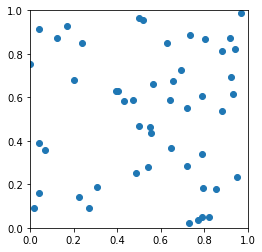

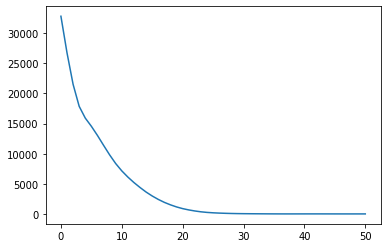


tensor(6.9977, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.9676, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.9085, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.8195, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.6680, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.4771, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.2994, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.2756, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.3853, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.4077, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.3069, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1649, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1141, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1420, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1791, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1977, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1874, dtype=to

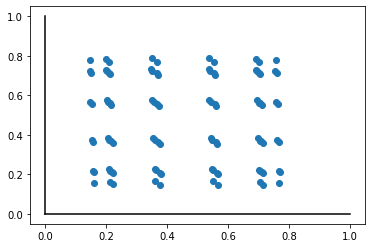

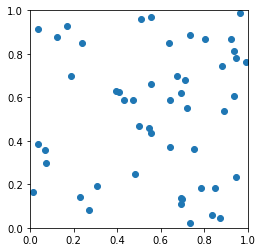

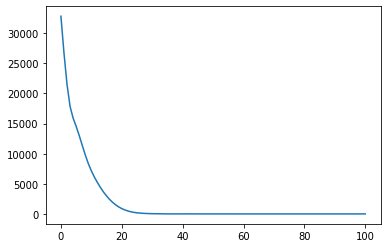


tensor(6.0975, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0787, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0972, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1104, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0811, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1151, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1353, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1031, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0832, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1010, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1005, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0952, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1302, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1386, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1150, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0810, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1045, dtype=to

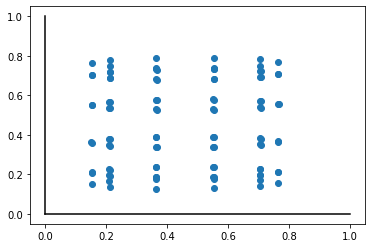

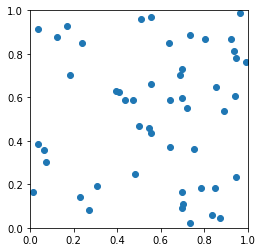

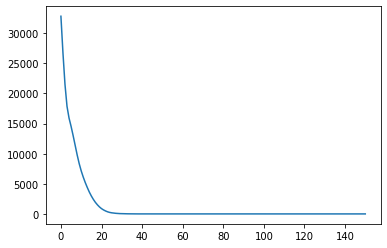


tensor(6.1124, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0879, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0956, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1117, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1069, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0905, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0943, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1143, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0991, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0823, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0953, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1007, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0835, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0846, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0955, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0866, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0798, dtype=to

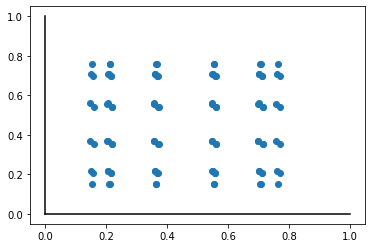

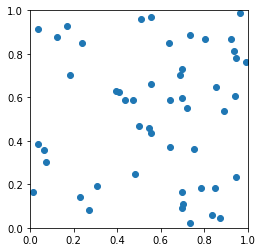

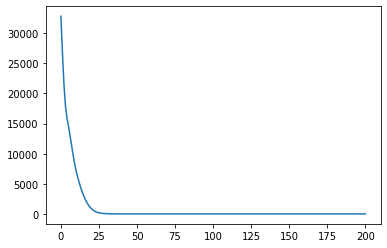


tensor(6.0800, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0876, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0840, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0853, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0838, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0836, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0826, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0837, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0838, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0826, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0805, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0886, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0880, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0794, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0784, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0892, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0859, dtype=to

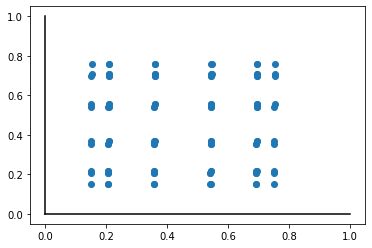

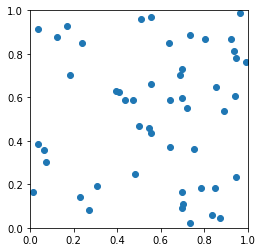

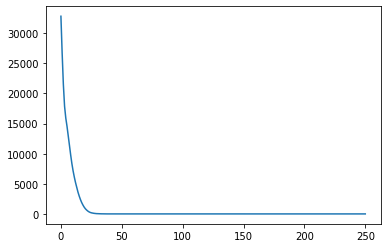


Training finished.


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 50,
              batch_size = 100,
              epochs = 5,
              train_steps = 50,
              lr1 = 0.05,
              lr2 = 0.05,
            init_phases = 'normal'
            )
print(time.time()-t0)
model1.train()

32822.387499524775
6.076987390610959


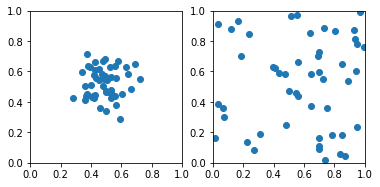

In [23]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,2)
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].scatter(p0[:,0],p0[:,1])
ax[0].set_aspect('equal', 'box')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].scatter(p1[:,0],p1[:,1])
ax[1].set_aspect('equal', 'box')

### 50 neurons, lr1=lr2 = 0.01, init_phases = uniform

0.0050008296966552734
tensor(24907.1794, dtype=torch.float64, grad_fn=<SumBackward0>)

run=0, time=1.25s


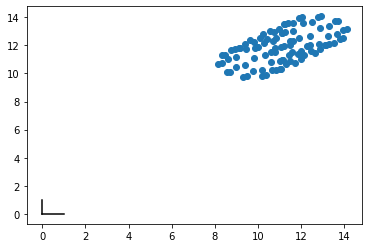

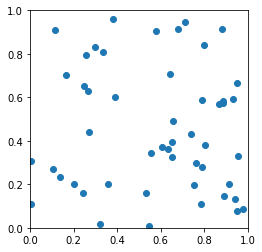

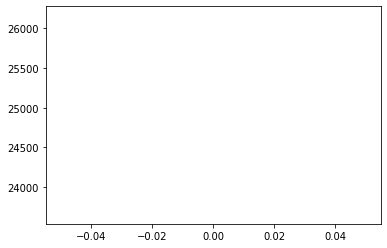


tensor(24254.0442, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(23649.6628, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(23083.4040, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(22552.5476, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(22050.9550, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(21568.5531, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(21093.4581, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(20622.0311, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(20159.7919, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(19704.2082, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(19261.2477, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(18829.7945, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(18406.4938, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(17990.6487, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(17586.9396, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(17190.2814, dtype

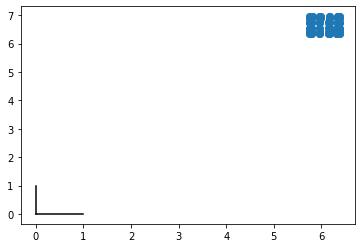

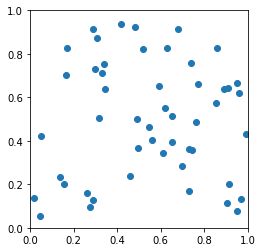

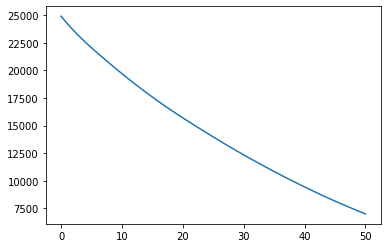


tensor(6770.3073, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6554.0687, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6342.4286, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6134.1016, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5929.1636, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5727.5666, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5532.4036, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5345.2219, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5164.5833, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4989.7078, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4817.4258, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4647.8296, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4480.9950, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4316.9701, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4155.8375, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(3997.6107, dtype=torch.float64, 

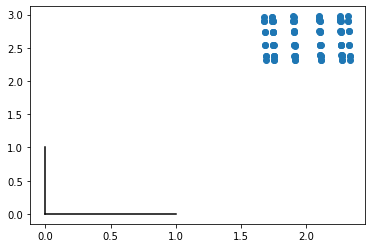

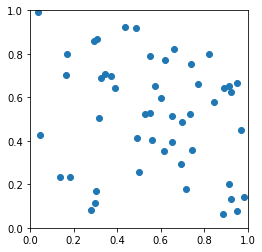

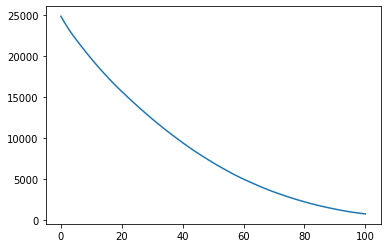


tensor(684.3455, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(641.7374, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(600.3555, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(561.1308, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(523.2254, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(486.9331, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(453.0202, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(420.2867, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(390.1372, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(361.1734, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(333.6367, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(309.8592, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(287.8464, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(266.5974, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(246.2890, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(227.9551, dtype=torch.float64, grad_fn=<SumBack

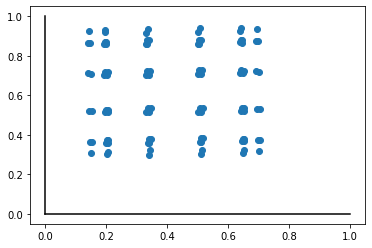

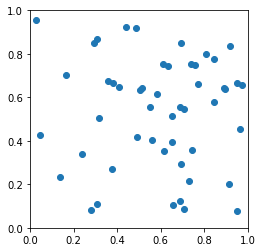

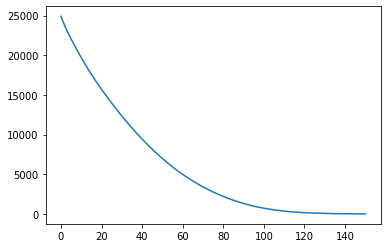


tensor(8.1610, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.5062, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.0115, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.6581, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.4243, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.2821, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.2167, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.2358, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.3322, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.4510, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.5409, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.5794, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.5682, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.5158, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.4460, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.3798, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.3153, dtype=to

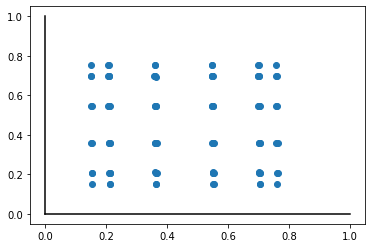

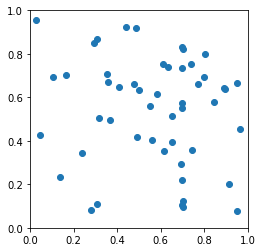

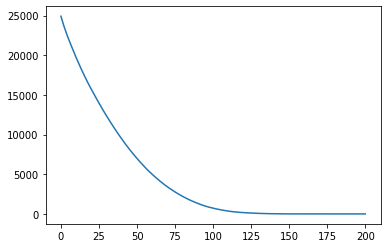


tensor(6.0740, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0755, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0764, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0781, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0762, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0754, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0740, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0794, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0821, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0766, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0807, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0823, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0749, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0809, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0885, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0826, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0759, dtype=to

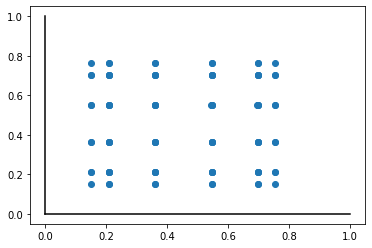

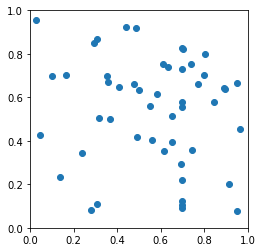

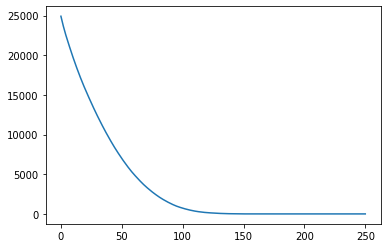


Training finished.


In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 50,
              batch_size = 100,
              epochs = 5,
              train_steps = 50,
              lr1 = 0.01,
              lr2 = 0.01,
            init_phases = 'uniform'
            )
print(time.time()-t0)
model1.train()

24907.179403358983
6.073647783341716


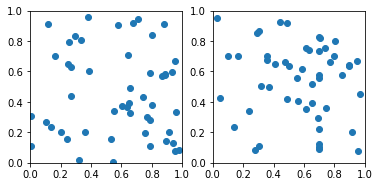

In [27]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,2)
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].scatter(p0[:,0],p0[:,1])
ax[0].set_aspect('equal', 'box')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].scatter(p1[:,0],p1[:,1])
ax[1].set_aspect('equal', 'box')

### 50 neurons, lr1=lr2 = 0.01, init_phases = uniform, init_weights = 'uniform'

0.003008604049682617
tensor(10925.3819, dtype=torch.float64, grad_fn=<SumBackward0>)

run=0, time=0.78s


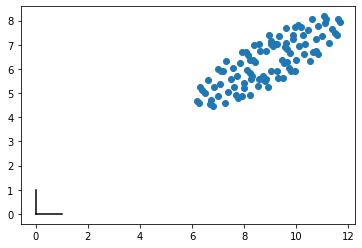

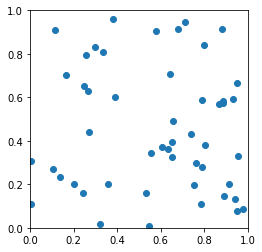

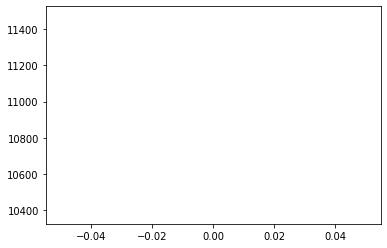


tensor(10368.6165, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(9843.5071, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(9348.0793, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(8885.8664, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(8449.6456, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(8033.9421, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7642.8348, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7267.3376, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6909.2439, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6564.6093, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6231.3567, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5909.2761, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5599.3739, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5306.1935, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5024.1409, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4752.3291, dtype=torch.float64,

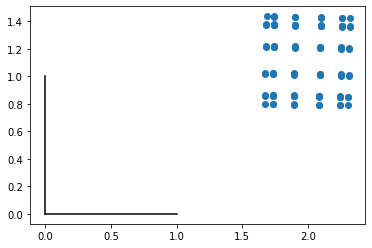

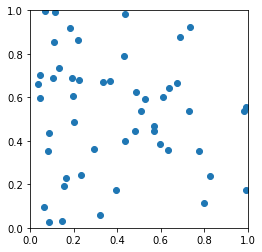

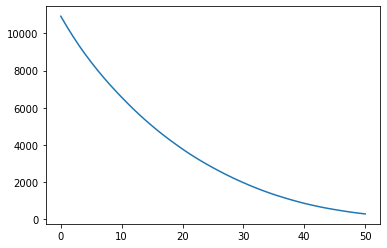


tensor(252.9504, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(219.1247, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(187.6960, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(159.0521, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(133.6731, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(111.1987, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(91.4918, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(74.4518, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(60.5700, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(48.5531, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(38.5603, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(30.6119, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(24.1116, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(18.7718, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(14.8115, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(11.8552, dtype=torch.float64, grad_fn=<SumBackward0>)

t

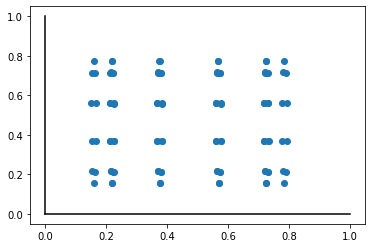

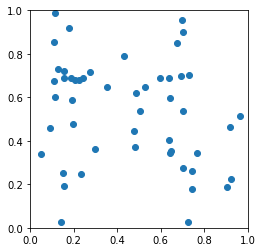

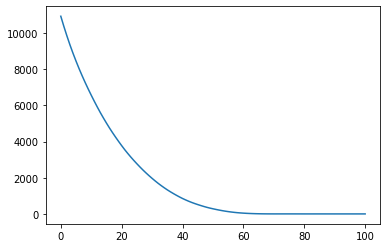


tensor(6.0907, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0808, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0883, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0957, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0937, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0826, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0759, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0831, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0848, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0774, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0828, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0894, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0839, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0786, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0796, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0790, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0785, dtype=to

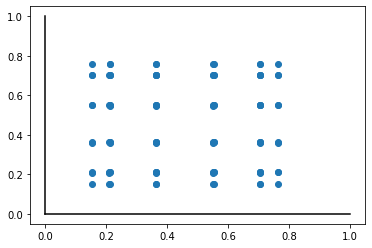

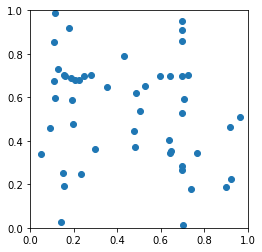

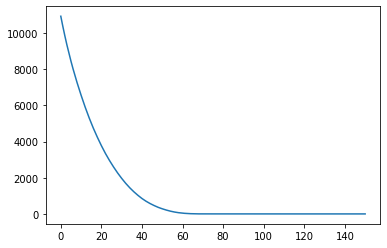


tensor(6.0742, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0741, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0749, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0740, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0783, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0793, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0742, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0806, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0869, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0818, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0742, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0818, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0895, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0845, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0752, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0796, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0878, dtype=to

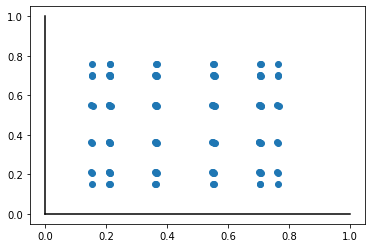

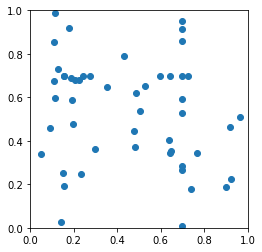

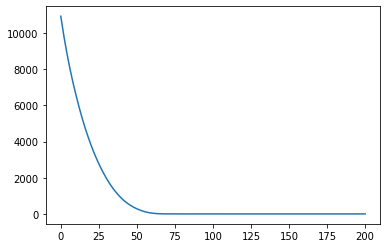


tensor(6.0740, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0758, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0765, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0742, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0764, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0775, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0746, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0766, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0790, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0764, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0749, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0754, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0739, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0773, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0795, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0758, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0745, dtype=to

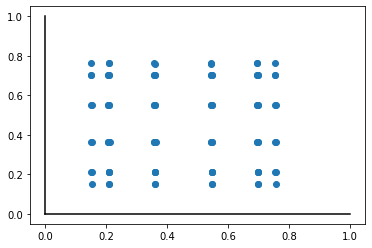

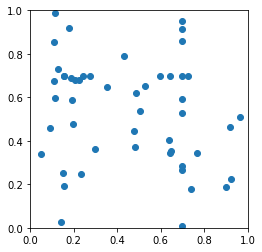

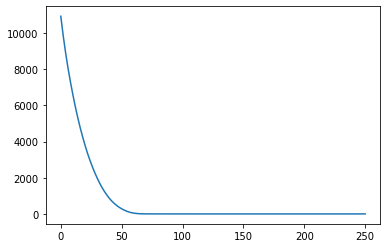


Training finished.


In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 50,
              batch_size = 100,
              epochs = 5,
              train_steps = 50,
              lr1 = 0.01,
              lr2 = 0.01,
            init_phases = 'uniform',
            init_weights = 'uniform'
            )
print(time.time()-t0)
model1.train()

10925.381923000048
6.073780720658414


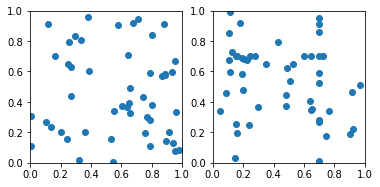

In [30]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,2)
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].scatter(p0[:,0],p0[:,1])
ax[0].set_aspect('equal', 'box')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].scatter(p1[:,0],p1[:,1])
ax[1].set_aspect('equal', 'box')

0.003963947296142578
tensor(10925.3819, dtype=torch.float64, grad_fn=<SumBackward0>)

run=0, time=0.83s


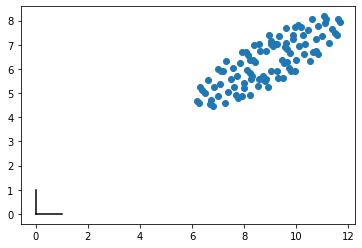

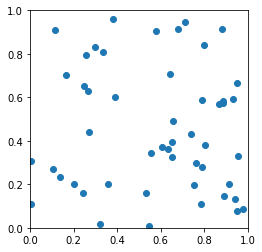

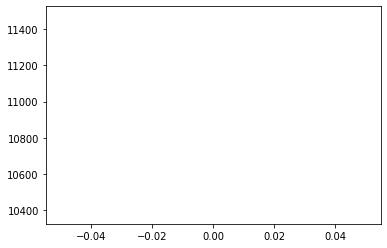


tensor(10366.0660, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(9837.5443, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(9338.6269, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(8867.7032, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(8422.1292, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7997.6246, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7588.8118, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7192.0762, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6806.2813, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6431.2119, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6067.0616, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5714.1886, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5372.8776, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(5043.1612, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4724.9653, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(4418.2999, dtype=torch.float64,

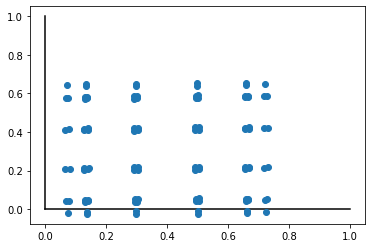

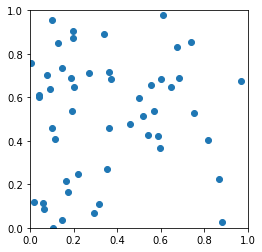

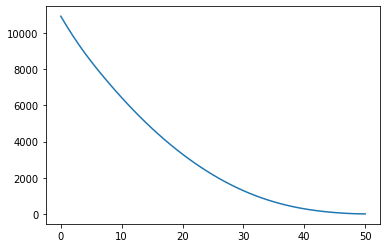


tensor(9.6667, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(15.5303, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(22.9840, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(29.7650, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(34.4334, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(36.3568, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(35.4908, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(32.2355, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(27.2946, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(21.5218, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(15.8613, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(11.1816, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(8.1843, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.0999, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(7.3322, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(8.2102, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(9.276

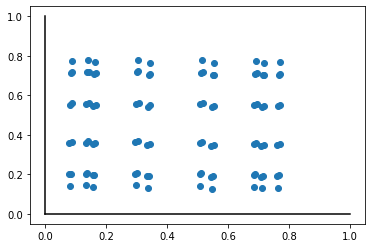

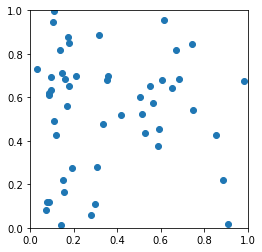

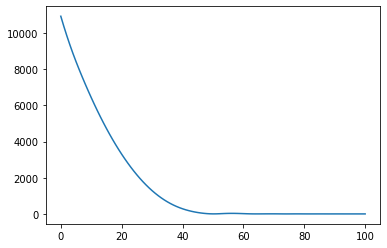


tensor(6.0768, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1005, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1415, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0991, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0780, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0616, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0698, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0915, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0401, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0871, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.1162, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0840, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0625, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0644, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0568, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0597, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0492, dtype=to

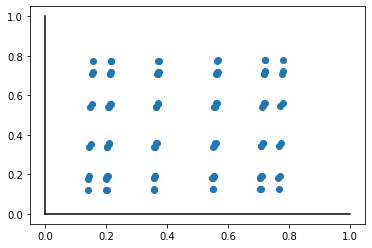

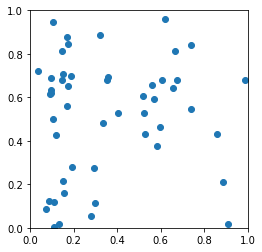

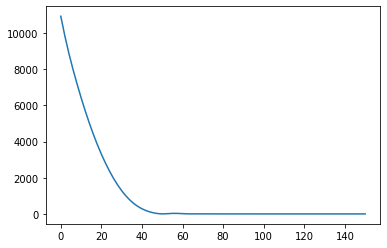


tensor(6.0489, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0547, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0520, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0437, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0400, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0545, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0443, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0591, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0577, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0407, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0377, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0567, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0495, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0506, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0476, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0463, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0408, dtype=to

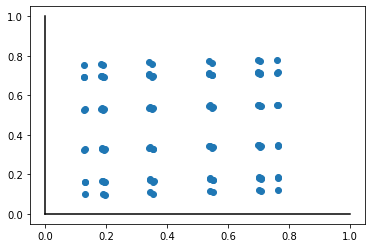

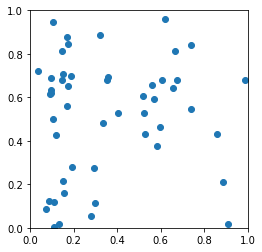

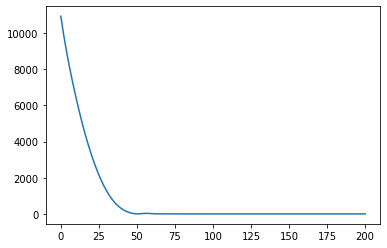


tensor(6.0388, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0900, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0766, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0550, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0517, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0592, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0504, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0695, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0685, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0428, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0451, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0550, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0551, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0668, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0659, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0503, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0447, dtype=to

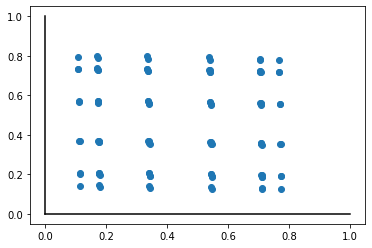

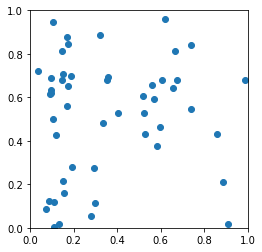

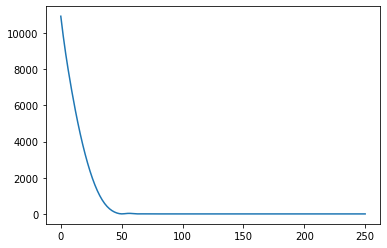


Training finished.


In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 50,
              batch_size = 100,
              epochs = 5,
              train_steps = 50,
              lr1 = 0.01,
              lr2 = 0.01,
            init_phases = 'uniform',
            init_weights = 'uniform',
            non_negative_weigths = False
            )
print(time.time()-t0)
model1.train()

10925.381923000048
6.0335725089766


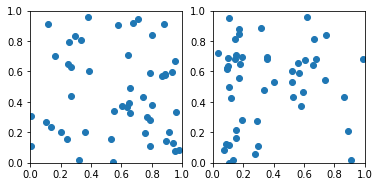

In [34]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,2)
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].scatter(p0[:,0],p0[:,1])
ax[0].set_aspect('equal', 'box')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].scatter(p1[:,0],p1[:,1])
ax[1].set_aspect('equal', 'box')

### 50 neurons, lr1=lr2 = 0.01, init_phases = uniform, init_weights = 'uniform'

0.004996299743652344
tensor(21.0401, dtype=torch.float64, grad_fn=<SumBackward0>)

run=0, time=0.61s


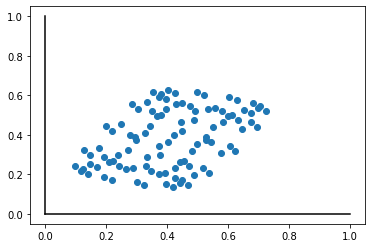

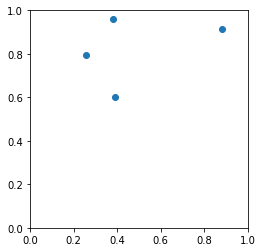

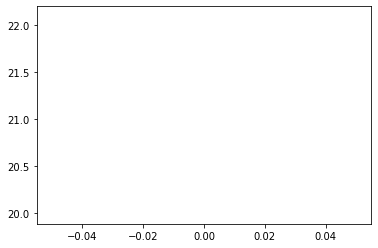


tensor(19.6420, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(18.3593, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(17.1845, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(16.1142, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(15.1474, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(14.2721, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(13.4683, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(12.7184, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(12.0121, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(11.3455, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(10.7206, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(10.1420, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(9.6156, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(9.1460, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(8.7345, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(8.3761, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(8.05

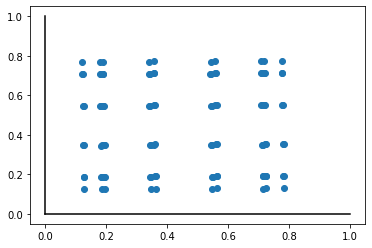

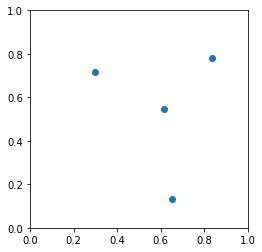

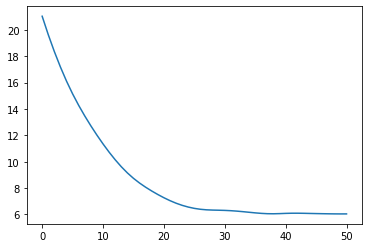


tensor(6.0368, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0387, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0389, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0374, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0351, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0334, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0322, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0309, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0308, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0305, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0294, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0299, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0313, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0304, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0289, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0285, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0287, dtype=to

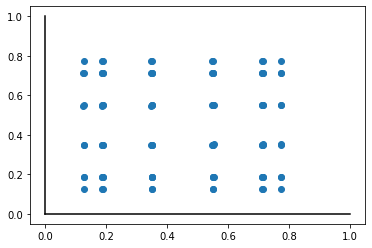

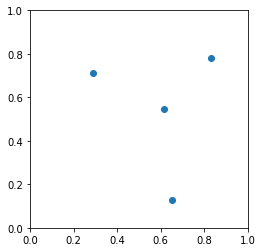

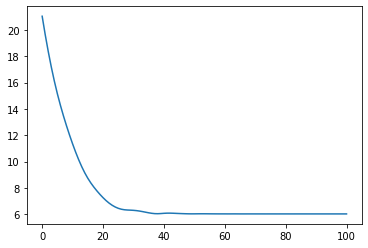


tensor(6.0280, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0283, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0280, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0280, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0284, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0283, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=to

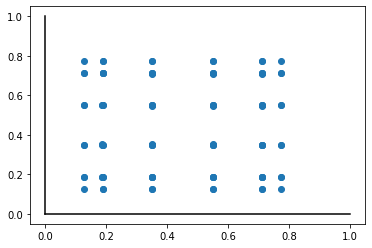

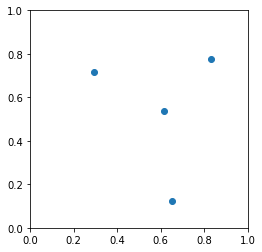

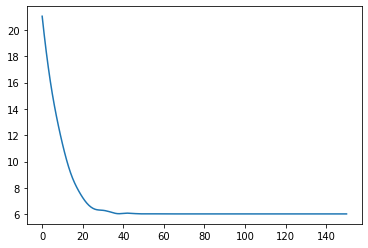


tensor(6.0287, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0292, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0284, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0284, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0283, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0280, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0283, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0283, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0284, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0286, dtype=to

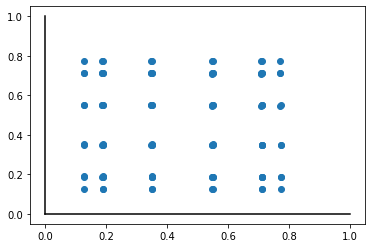

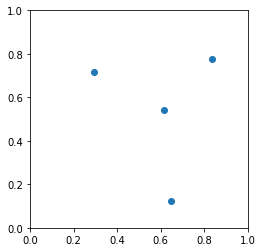

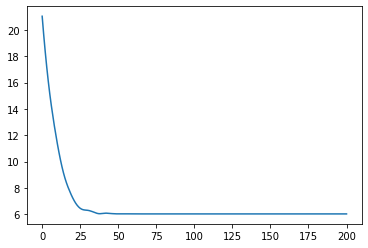


tensor(6.0283, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0284, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0283, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0283, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0282, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=torch.float64, grad_fn=<SumBackward0>)

tensor(6.0281, dtype=to

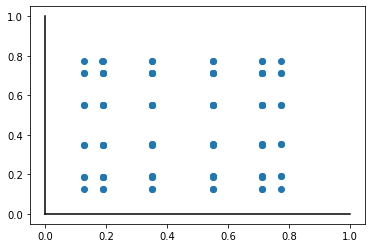

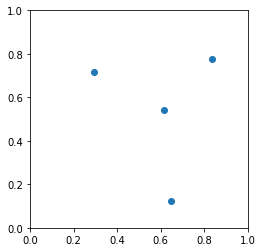

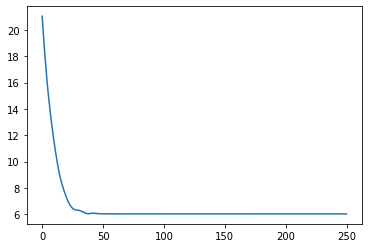


Training finished.


In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 4,
              batch_size = 100,
              epochs = 5,
              train_steps = 50,
              lr1 = 0.01,
              lr2 = 0.01,
            init_phases = 'uniform',
            init_weights = 'uniform',
            non_negative_weigths = False

            )
print(time.time()-t0)
model1.train()

21.040118838231546
6.027975072146525


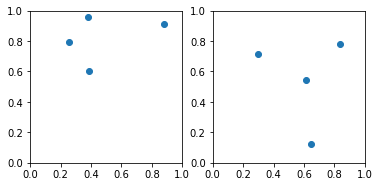

In [36]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,2)
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].scatter(p0[:,0],p0[:,1])
ax[0].set_aspect('equal', 'box')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].scatter(p1[:,0],p1[:,1])
ax[1].set_aspect('equal', 'box')